In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH = '/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design'
sys.path.append(ROOT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# This cell prepares the Colab environment by copying and
# extracting the dataset from Google Drive to the fast local SSD.

import os
import time

# --- Part 1: Colab Local Data Setup ---
print("Starting data setup...")
start_setup_time = time.time()

# --- Define paths ---
DRIVE_ARCHIVE_PATH = "/content/drive/MyDrive/datasets/cropped_celeba.tar"
LOCAL_ARCHIVE_PATH = "/content/cropped_celeba.tar"
EXTRACT_PATH = "/content/celeba_dataset"

# The final, correct path to the images, based on our investigation
LOCAL_DATA_DIR = os.path.join(EXTRACT_PATH, "content", "cropped_celeba")

# --- Logic ---
# Only copy/untar if the local data directory doesn't already exist
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"Copying {DRIVE_ARCHIVE_PATH} to local runtime...")
    if not os.path.exists(DRIVE_ARCHIVE_PATH):
        print(f"[FATAL ERROR] Source file not found: {DRIVE_ARCHIVE_PATH}")
        raise FileNotFoundError(f"Source file not found: {DRIVE_ARCHIVE_PATH}")

    # 1. Copy the single .tar file from Drive (fast)
    !cp "{DRIVE_ARCHIVE_PATH}" "{LOCAL_ARCHIVE_PATH}"
    print("Copy complete.")

    # 2. Extract the archive to the local SSD (fast)
    print(f"Untarring {LOCAL_ARCHIVE_PATH} to {EXTRACT_PATH}...")
    !mkdir -p "{EXTRACT_PATH}"
    !tar -xf "{LOCAL_ARCHIVE_PATH}" -C "{EXTRACT_PATH}"
    print("Untar complete.")

    # 3. Clean up the local archive to save space
    !rm "{LOCAL_ARCHIVE_PATH}"
else:
    print(f"Data directory {LOCAL_DATA_DIR} already exists. Skipping copy/untar.")

print(f"Data setup finished in {time.time() - start_setup_time:.2f} seconds.")

# --- Sanity Check ---
# Crucial check to ensure data exists before proceeding
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"\n[FATAL ERROR] The expected data directory does not exist: {LOCAL_DATA_DIR}")
    raise FileNotFoundError(f"Could not find data at {LOCAL_DATA_DIR}")
else:
    print(f"Successfully found data at: {LOCAL_DATA_DIR}")

Starting data setup...
Data directory /content/celeba_dataset/content/cropped_celeba already exists. Skipping copy/untar.
Data setup finished in 0.00 seconds.
Successfully found data at: /content/celeba_dataset/content/cropped_celeba


In [4]:
import torch
import sys

from src.utils.data_utils import get_dataloaders

# --- Configuration ---
# Use the local data path defined in Cell 1
DATA_ROOT = LOCAL_DATA_DIR
BATCH_SIZE = 256
IMAGE_SIZE = 128
RANDOM_SEED = 42

# --- 1. Get Dataloaders ---
# This single function call does all the work
train_loader, val_loader, test_loader = get_dataloaders(
    root_dir=DATA_ROOT,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    random_seed=RANDOM_SEED
)

# --- 2. Verification ---
# Final check to ensure the dataloader works
if train_loader:
    print("\nVerifying one batch from train_loader...")
    try:
        # Get one sample batch
        images, labels = next(iter(train_loader))
        print(f"  Batch loaded successfully.")
        print(f"  Image batch shape: {images.shape}")
        print("\nSetup complete. You are ready to start training.")
    except Exception as e:
        print(f"  [Error] Failed to load batch: {e}")
else:
    print("\nData loading failed. Please check previous cell output.")


Loading dataset from: /content/celeba_dataset/content/cropped_celeba
Searching for '*.jpg' files in: /content/celeba_dataset/content/cropped_celeba
Successfully found 199509 images.
Successfully loaded 199509 total images.
Splitting dataset into:
  Train: 159607 images
  Validation: 19950 images
  Test: 19952 images

DataLoaders created successfully.

Verifying one batch from train_loader...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Batch loaded successfully.
  Image batch shape: torch.Size([256, 3, 128, 128])

Setup complete. You are ready to start training.


Skipping the first 10 batches to get new images...
Successfully loaded 4 different sample images from VAL_LOADER.

--- Processing Model: face_autoencoder_512.pth ---
Model loaded successfully.

--- Processing Model: face_autoencoder_512_SSIM.pth ---
Model loaded successfully.

--- Processing Model: face_autoencoder_512_L1_SSIM.pth ---
Model loaded successfully.


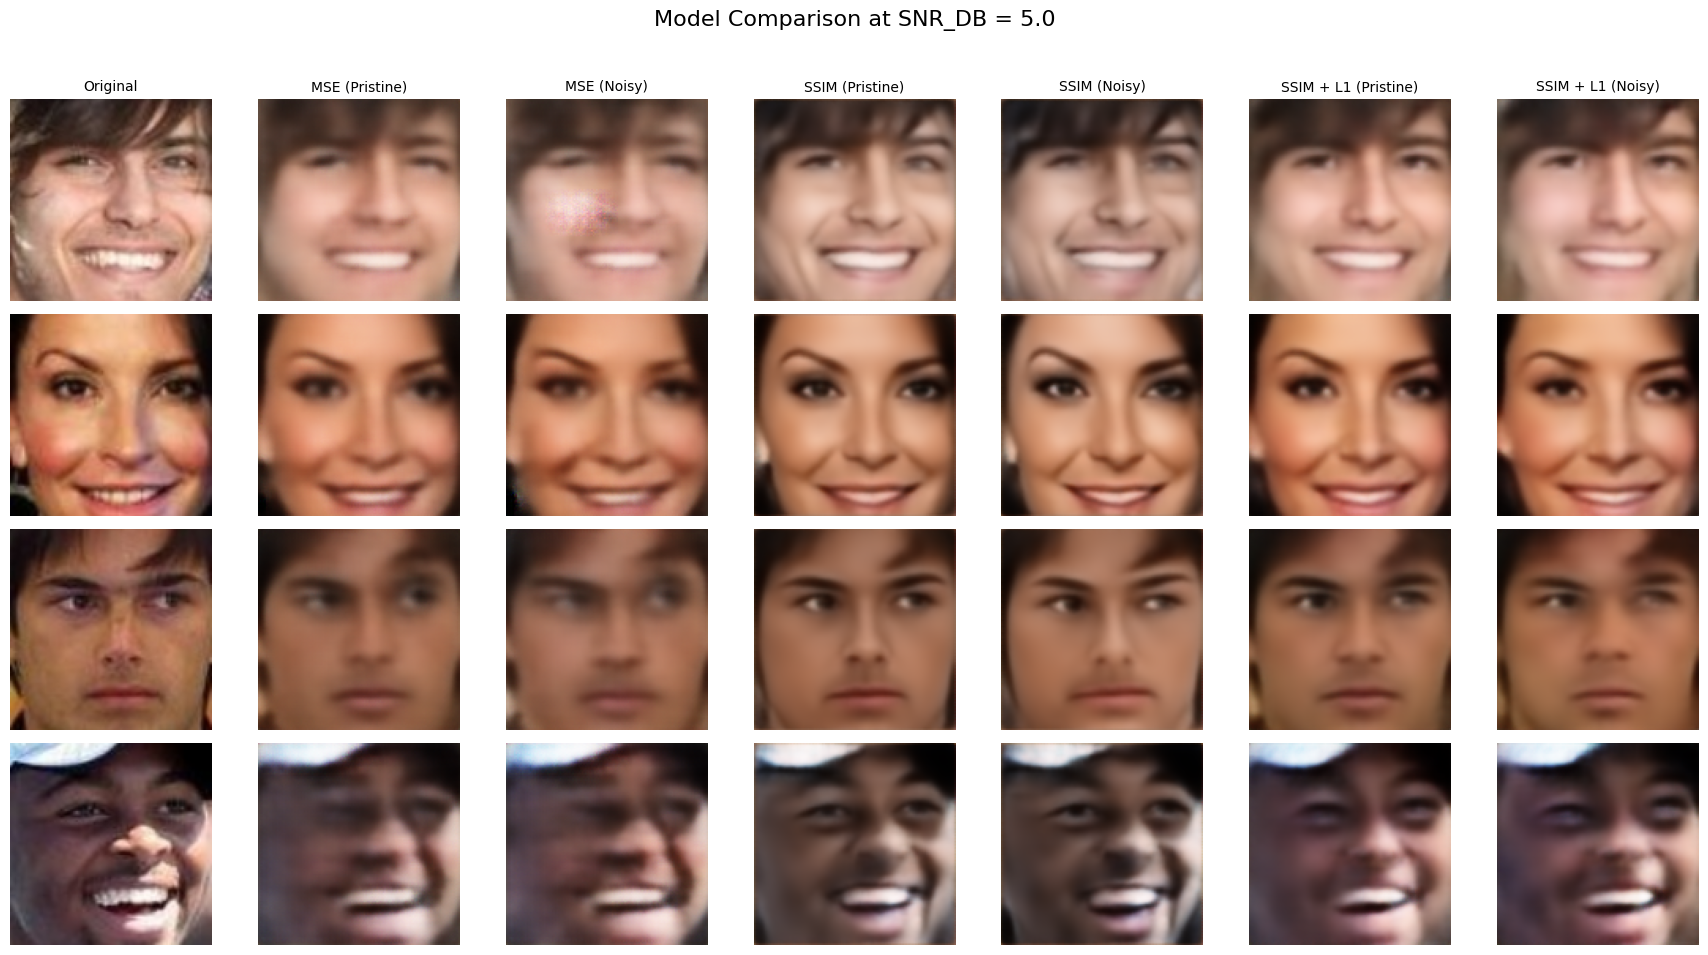

In [7]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# --- 1. Module and Dataloader Setup ---
from src.utils.channels import awgn_channel
from src.models.face_autoencoder import FaceAutoencoder

# (Assume val_loader and device are loaded from the previous cell)

# -----------------------------------------------
# 2. Configuration for Visualization
# -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/drive/MyDrive/models"
VISUALIZE_SNR_DB = 5.0
NUM_IMAGES_TO_SHOW = 4

# --- 비교할 모델 목록 ---
MODEL_CONFIGS = [
    (512, "_512.pth", "MSE"),
    (512, "_512_SSIM.pth", "SSIM"),
    (512, "_512_L1_SSIM.pth", "SSIM + L1")
]

# -----------------------------------------------
# 3. Plotting Function (변경 없음)
# -----------------------------------------------
def imshow(ax, tensor, title=None):
    """Matplotlib 축(axis)에 텐서 이미지를 플로팅하는 함수"""
    img_np = tensor.cpu().numpy()
    img_np = (img_np / 2.0) + 0.5
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(np.transpose(img_np, (1, 2, 0)))
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=10)

# -----------------------------------------------
# 4. 👈 (MODIFIED) Get a *Different* Batch of Validation Images
# -----------------------------------------------
try:
    data_iter = iter(val_loader)

    # --- 다른 이미지를 보기 위해, 앞부분의 배치를 건너뜁니다 ---
    # 이 값을 바꾸면 다른 인물들을 볼 수 있습니다 (예: 20)
    batches_to_skip = 10
    print(f"Skipping the first {batches_to_skip} batches to get new images...")
    for _ in range(batches_to_skip):
        next(data_iter) # 이 코드가 배치를 하나씩 넘깁니다.

    # 건너뛴 후, 다음 배치를 시각화에 사용합니다.
    images, _ = next(data_iter)
    images = images.to(device)
    sample_images = images[:NUM_IMAGES_TO_SHOW]
    print(f"Successfully loaded {NUM_IMAGES_TO_SHOW} different sample images from VAL_LOADER.")

except NameError:
    print("[ERROR] val_loader is not defined. Please run the Dataloader setup cell first.")
    exit()
except StopIteration:
    # batches_to_skip 값이 너무 클 경우 발생할 수 있습니다.
    print("[ERROR] val_loader ran out of images. Try a smaller number for 'batches_to_skip'.")
    exit()

# -----------------------------------------------
# 5. Main Plotting Loop (변경 없음)
# -----------------------------------------------

# --- 각 모델별 복원 결과를 저장 ---
reconstruction_results = {}

for latent_dim, suffix, display_name in MODEL_CONFIGS:
    model_name = f"face_autoencoder{suffix}"
    MODEL_PATH = os.path.join(SAVE_DIR, model_name)
    print(f"\n--- Processing Model: {moㅁdel_name} ---")

    model = FaceAutoencoder(latent_dim=latent_dim).to(device)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval()
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"[ERROR] Model file not found at {MODEL_PATH}. Skipping.")
        reconstruction_results[display_name] = {'pristine': None, 'noisy': None}
        continue

    with torch.no_grad():
        latent_original = model.encode(sample_images)
        latent_noisy = awgn_channel(latent_original, snr_db=VISUALIZE_SNR_DB)
        recon_pristine = model.decode(latent_original)
        recon_noisy = model.decode(latent_noisy)
        reconstruction_results[display_name] = {
            'pristine': recon_pristine,
            'noisy': recon_noisy
        }

# --- 하나의 큰 그림으로 모든 결과 플로팅 (Side-by-Side) ---
num_cols_per_image = 1 + len(MODEL_CONFIGS) * 2
num_rows = NUM_IMAGES_TO_SHOW

fig, axes = plt.subplots(num_rows, num_cols_per_image, figsize=(num_cols_per_image * 2.5, num_rows * 2.5))
fig.suptitle(f"Model Comparison at SNR_DB = {VISUALIZE_SNR_DB}", fontsize=16)

# --- 각 열의 헤더(제목) 정의 ---
column_titles = ["Original"]
for _, _, display_name in MODEL_CONFIGS:
    column_titles.append(f"{display_name} (Pristine)")
    column_titles.append(f"{display_name} (Noisy)")

# --- 이미지 플로팅 ---
for row_idx in range(NUM_IMAGES_TO_SHOW):

    # 1. 원본 이미지 (첫 번째 열)
    imshow(axes[row_idx, 0], sample_images[row_idx],
           title=column_titles[0] if row_idx == 0 else None)

    col_offset = 1
    for _, _, display_name in MODEL_CONFIGS:
        recons = reconstruction_results.get(display_name, {'pristine': None, 'noisy': None})

        # 2. Pristine 복원
        if recons['pristine'] is not None:
            imshow(axes[row_idx, col_offset], recons['pristine'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

        # 3. Noisy 복원
        if recons['noisy'] is not None:
            imshow(axes[row_idx, col_offset], recons['noisy'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()